<a href="https://colab.research.google.com/github/Kienknu/Kienknu/blob/main/Kien_SOA_Mechanism_0410_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 29.2 MB/s eta 0:00:00


In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdChemReactions
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display
from rdkit.Chem import Descriptors
import pandas as pd
import requests
import io

In [22]:
chemical_space_1 = {'Cc1ccccc1'}  # Toluene

reacting_species = {'[OH]', '[N](=O)', '[N+](=O)[O-]', 'O=O', 'N([H])([H])[H]'}
num_iterations = 8

In [23]:
reaction_rules = [
    # 1: Radical formation
    AllChem.ReactionFromSmarts('[cH:1]>>[cH:1][*]'), #37

    #2: using MCM rules

    # Toluene + OH >> TLBIPERO2 (1)
    AllChem.ReactionFromSmarts('[cH:1]>>[#6]C12[#8]-[#8]-[#6](-[#6]1-[#8])-[#6](-[#8]-[#8])-[#6]=[#6]2'),

    # TLBIPERO2 >> TLBIPERO (1.1)
    AllChem.ReactionFromSmarts('[#6]C12[#8]-[#8]-[#6](-[#6]1-[#8])-[#6](-[#8]-[#8])-[#6]=[#6]2>>[#6]C12[#8]-[#8]-[#6](-[#6]1-[#8])-[#6](-[#8])-[#6]=[#6]2'),

    # TLBIPERO (1.1) >> GLYOX + C5DICARB (1.1.1)
    AllChem.ReactionFromSmarts('[#6]C12[#8]-[#8]-[#6](-[#6]1-[#8])-[#6](-[#8])-[#6]=[#6]2>>O=[#6]-[#6]=O.[#6]-[#6](=O)-[#6]=[#6]-[#6]=O'),

    # C5DICARB >> C5DICARBO2 (1.1.1.3)
    AllChem.ReactionFromSmarts('[#6]-[#6](=O)-[#6]=[#6]-[#6]=O>>[#6]-[#6](=O)-[#6](-[#8]-[#8])-[#6](-[#8])-[#6]=O'),
    # C5DICARBO2 >> C5134CO2OH (1.1.1.3.5)
    AllChem.ReactionFromSmarts('[#6]-[#6](=O)-[#6](-[#8]-[#8])-[#6](-[#8])-[#6]=O>>[#6]-[#6](=O)-[#6](=O)-[#6](-[#8])-[#6]=O'),#54
    # C5DICARBO2 >> C514CO23OH (1.1.1.3.6)
    AllChem.ReactionFromSmarts('[#6]-[#6](=O)-[#6](-[#8]-[#8])-[#6](-[#8])-[#6]=O>>[#6]-[#6](=O)-[#6](-[#8])-[#6](-[#8])-[#6]=O'),#57

    # C5DICARB >> C5CO14O2 (1.1.1.4)
    AllChem.ReactionFromSmarts('[#6]-[#6](=O)-[#6]=[#6]-[#6]=O>>[#6]-[#6](=O)-[#6]=[#6]-[#6](=O)-[#8]-[#8]'),#58
    # C5CO14O2 >> C5COO2NO2 (1.1.1.4.2)
    AllChem.ReactionFromSmarts('[#6]-[#6](=O)-[#6]=[#6]-[#6](=O)-[#8]-[#8]>>[#6]-[#6](=O)-[#6]=[#6]-[#6](=O)-[#8]-[#8]N(=O)=O'),#60

    # TLBIPERO >> MGLYOX + MALDIAL (1.1.3)
    AllChem.ReactionFromSmarts('[#6]C12[#8]-[#8]-[#6](-[#6]1-[#8])-[#6](-[#8])-[#6]=[#6]2>>[#6]-[#6](=O)-[#6]=O.O=[#6]-[#6]=[#6]-[#6]=O'), #69

    # OH addition
    AllChem.ReactionFromSmarts('[cH:1]>>[cH:1][OH]'),

    #3: NO2 addition
    AllChem.ReactionFromSmarts('[cH:1]>>[cH:1][N+](=O)[O-]'),

    #4: NO addition
    AllChem.ReactionFromSmarts('[cH:1]>>[cH:1][N](=O)'),

    #5. Oxidation
    AllChem.ReactionFromSmarts('[C:1](=O)>>[C:1](=O)[OH]'),

    #6. Amidation
    AllChem.ReactionFromSmarts('[C:1](=O)[OH]>>[C:1](=O)[NH2]'),

    #7. Peroxidation
    AllChem.ReactionFromSmarts('[cH:1]>>[cH:1][O][O]'),

    #8.Aromatic ring degradation
    AllChem.ReactionFromSmarts('[cH:1]>>[C](=O)O.[C](=O)O'),#3035

    ##AllChem.ReactionFromSmarts('[cH:1]>>[C:1](O)[C:2](O)C=CC=CO'), #c1ccccc1 #3035

    ##AllChem.ReactionFromSmarts('[cH:1]>>[C:1](=O)[NH2].[C:2](=O)O'),#3035

    #AllChem.ReactionFromSmarts('[cH:1]>>[C](=O)[N+](=O)[O-].[C](=O)O'),#3038
    #AllChem.ReactionFromSmarts('[cH:1]>>[C][N+](=O)[O-].[C](=O)O'),#3036
    #AllChem.ReactionFromSmarts('[cH:1][N+](=O)[O-]>>[C][N+](=O)[O-].[C](=O)([N+](=O)[O-])'),#3035
    #AllChem.ReactionFromSmarts('[cH:1][N+](=O)[O-]>>[C][N+](=O)[O-].[C](=O)'),#3035
    #AllChem.ReactionFromSmarts('[cH:1]>>[C][N+](=O)[O-].[C](=O)([N+](=O)[O-])'),#3039
    #AllChem.ReactionFromSmarts('[cH:1]>>[C](=O)[N+](=O)[O-].[C](=O)([N+](=O)[O-])'),#3038

    #AllChem.ReactionFromSmarts('[cH:1]>>[C](=O)[N](=O).[C](=O)O'), #3042
    #AllChem.ReactionFromSmarts('[cH:1]>>[C](=O)[N](=O).[C][N](=O)'), #3043

    ######### Different form ##########
    # 1. Generic ring cleavage to two acids
    #AllChem.ReactionFromSmarts('c1([*:7])c([*:8])cccc1 >> [C:1](=O)O.[C:2](=O)O'),#3035

    # 2. Ring oxidation
    #AllChem.ReactionFromSmarts('c1([*:1])c([*:2])cccc1 >> [C:1](O)[C:2](O)C=CC=CO'),

    # 3. Oxidative ring cleavage with amide formation
    #AllChem.ReactionFromSmarts('c1([*:1])c([*:2])cccc1 >> [C:1](=O)[NH2].[C:2](=O)O'),

    # 4. Oxidation to nitro-containing compound
    #AllChem.ReactionFromSmarts('c1([*:1])c([*:2])cccc1>>[C:1](=O)[N+](=O)[O-].[C:2](=O)O'),#3038
    #AllChem.ReactionFromSmarts('c1c([*:1])c([*:2])ccc1>>[C:1](=O)[N+](=O)[O-].[C:2](=O)O'),#3038
    #AllChem.ReactionFromSmarts('c1([*:1])c([*:2])cccc1[N+](=O)[O-] >> [C:1](=O)[N+](=O)[O-].[C:2](=O)'),#3040
    #AllChem.ReactionFromSmarts('c1c([*:1])c([*:2])ccc1[N+](=O)[O-] >> [C:1](=O)[N+](=O)[O-]CCC[C:2](=O)'),#3030
    #AllChem.ReactionFromSmarts('c1([*:1])c([*:2])c([*:3])c([*:4])c([*:5])c1([N+](=O)[O-])>>[C:1](=O)[N+](=O)[O-].[*:2].[*:3].[*:4].[*:5].[C:5](=O)'),#3043
    #AllChem.ReactionFromSmarts('c1([*:1])c([*:2])c([*:3])c([*:4])c([*:5])c1([NX3](=[OX1])=[OX2])>>[C:1](=[OX1])[NX3](=[OX1])[OX2].[*:2].[*:3].[*:4].[*:5].[C:5](=[OX1])')#3030

    # 5. Nitroso product
    #AllChem.ReactionFromSmarts('c1([*:1])c([*:2])cccc1 >> [C:1](=O)[N](=O).[C:2](=O)O'),
    #AllChem.ReactionFromSmarts('c1([*:1])c([*:2])cccc1[N](=O) >> [C:1](=O)[N](=O).[C:2](=O)'),#3043
    #AllChem.ReactionFromSmarts('c1([*:1])c([*:2])c([*:3])c([*:4])c([*:5])c1([N](=O))>>[C:1](=O)[N](=O).[*:2].[*:3].[*:4].[*:5].[C:5](=O)'),

]

In [24]:
# radical formation
def create_aromatic_radical(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    radical = Chem.MolFromSmarts("[c*]")

    if mol.HasSubstructMatch(radical):
      return Chem.MolToSmiles(mol)
    else:
      return None


# trace the reaction
reaction_history = []

def trace_reaction_path(target_product_smiles, reaction_history):
    reaction_path = []
    current_product = target_product_smiles
    for i in range(len(reaction_history) - 1, -1, -1):
        if reaction_history[i][2] == current_product:
            reaction_path.insert(0, reaction_history[i])
            current_product = reaction_history[i][0]
    return reaction_path

# Reaction
for _ in range(num_iterations):
    temp_new_products = set()
    for reactant_smiles in chemical_space_1.copy():
        reactant_mol = Chem.MolFromSmiles(reactant_smiles)
        if reactant_mol:

            # Apply reaction rules
            for rxn_index, rxn in enumerate(reaction_rules):
                possible_products = rxn.RunReactants((reactant_mol,))
                for prod_set in possible_products:
                    for prod in prod_set:
                        try:
                            prod_smiles = Chem.MolToSmiles(prod)

                            # radical correction
                            if "[c*]" in prod_smiles:
                                prod_smiles = create_aromatic_radical(reactant_smiles)

                            if prod_smiles not in chemical_space_1:
                                temp_new_products.add(prod_smiles)
                                reaction_history.append((reactant_smiles, rxn_index, prod_smiles))
                        except:
                            pass

            # React with reacting species
            for species in reacting_species:
                try:
                    combined_smiles = reactant_smiles #+ "." + species
                    combined_mol = Chem.MolFromSmiles(combined_smiles)

                    if combined_mol:

                        temp_new_products.add(Chem.MolToSmiles(combined_mol))
                except:
                    pass

    chemical_space_1.update(temp_new_products)

[13:35:50] product 0 has no mapped atoms.
[13:35:50] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 1 
[13:35:50] reactant 0 has no mapped atoms.
[13:35:50] product 0 has no mapped atoms.
[13:35:50] reactant 0 has no mapped atoms.
[13:35:50] product 0 has no mapped atoms.
[13:35:50] product 1 has no mapped atoms.
[13:35:50] reactant 0 has no mapped atoms.
[13:35:50] product 0 has no mapped atoms.
[13:35:50] reactant 0 has no mapped atoms.
[13:35:50] product 0 has no mapped atoms.
[13:35:50] reactant 0 has no mapped atoms.
[13:35:50] product 0 has no mapped atoms.
[13:35:50] reactant 0 has no mapped atoms.
[13:35:50] product 0 has no mapped atoms.
[13:35:50] reactant 0 has no mapped atoms.
[13:35:50] product 0 has no mapped atoms.
[13:35:50] reactant 0 has no mapped atoms.
[13:35:50] product 0 has no mapped atoms.
[13:35:50] product 1 has no mapped atoms.
[13:35:50] product 0 has no mapped atoms.
[13:35:50] product 1 has no mapped atoms.
[13:35:50

In [25]:
# Create Mol objects
smiles_list_1 = list(chemical_space_1)

mols = []
valid_smiles = []

for smi in smiles_list_1:
    mol = Chem.MolFromSmiles(smi)

    if mol:

        if Chem.SanitizeMol(mol, catchErrors=True) == Chem.SanitizeFlags.SANITIZE_NONE:
            mols.append(mol)
            valid_smiles.append(smi)
        else:
            print(f"Invalid SMILES: {smi}")

[13:37:11] Explicit valence for atom # 1 C, 5, is greater than permitted
[13:37:11] Explicit valence for atom # 5 C, 5, is greater than permitted
[13:37:11] Explicit valence for atom # 1 C, 5, is greater than permitted
[13:37:11] Explicit valence for atom # 1 C, 5, is greater than permitted
[13:37:11] Explicit valence for atom # 7 C, 5, is greater than permitted
[13:37:11] Explicit valence for atom # 5 C, 5, is greater than permitted
[13:37:11] Explicit valence for atom # 3 C, 5, is greater than permitted
[13:37:11] Explicit valence for atom # 1 C, 5, is greater than permitted
[13:37:11] Explicit valence for atom # 1 C, 5, is greater than permitted
[13:37:11] Explicit valence for atom # 1 C, 5, is greater than permitted
[13:37:11] Explicit valence for atom # 8 C, 5, is greater than permitted
[13:37:11] Explicit valence for atom # 1 C, 5, is greater than permitted
[13:37:12] Explicit valence for atom # 7 C, 5, is greater than permitted
[13:37:12] Explicit valence for atom # 2 C, 5, is g

In [26]:
len(mols)

7464

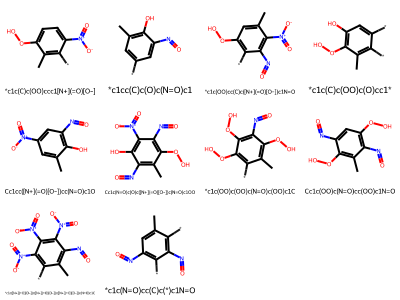

In [27]:
# set a limit and display
max_mols_to_draw = 10
mols_to_draw = mols[:min(len(mols), max_mols_to_draw)]
legends_to_draw = valid_smiles[:min(len(valid_smiles), max_mols_to_draw)]


img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=4, subImgSize=(100, 100),
                             legends=legends_to_draw,
                             maxMols=len(mols_to_draw),useSVG=True)
display(img)

In [28]:
# calculate molecular weight in mols object

calculated_mw = []
for mol in mols:
  mw = Chem.Descriptors.ExactMolWt(mol)
  calculated_mw.append(mw)

Comparison of molecular mass with that in the toluene experiment

In [29]:
# online file
url = "https://docs.google.com/spreadsheets/d/1pBx8tnFjT5FHe-KaPjAOxNMYgYAr6ie-/edit?usp=sharing&ouid=105784435570061437896&rtpof=true&sd=true"

# spreadsheet ID
spreadsheet_id = url.split("/d/")[1].split("/")[0]

# Excel export URL
excel_export_url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=xlsx"

# Download the data
response = requests.get(excel_export_url)
response.raise_for_status()

# Read the data
exp_data = pd.read_excel(io.BytesIO(response.content), sheet_name='Tol_NH3_CHON', engine='openpyxl')

exp_data

,Class,DBE,Neutral_DBE,Formula,Exp_m/z,neutral_mass,pos_mass,Mono_Abund,Total_Abund,Calc_m/z,#C,#H,#N,#O,#S,H/C,N/C,O/C,S/C,Osc
0,NO4,5.5,5,C7H7NO4,168.030370,169.038195,170.045995,84906561.99,91434808.22,168.030231,7,7,1,4,0,1.0000,0.1429,0.5714,0,-0.4286
1,NO4,5.5,5,C6H5NO4,154.014731,155.022556,156.030356,61072644.65,64970660.40,154.014581,6,5,1,4,0,0.8333,0.1667,0.6667,0,-0.1666
2,N2O6,6.5,6,C7H6N2O6,213.015519,214.023344,215.031144,15825731.09,17159318.81,213.015309,7,6,2,6,0,0.8571,0.2857,0.8571,0,0.0000
3,N2O10,3.5,3,C7H12N2O10,283.042127,284.049952,285.057752,13027120.30,14047110.36,283.041918,7,12,2,10,0,1.7143,0.2857,1.4286,0,-0.2857
4,N3O13,3.5,3,C7H13N3O13,346.037477,347.045302,348.053102,9003501.35,9746036.59,346.037561,7,13,3,13,0,1.8571,0.4286,1.8571,0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,N3O16,-0.5,-1,C5H17N3O16,374.053764,375.061589,376.069389,101581.36,101581.36,374.053605,5,17,3,16,0,3.4000,0.6000,3.2000,0,-0.2000
579,N3O16,2.5,2,C10H21N3O16,438.085625,439.093450,440.101250,101429.03,101429.03,438.084905,10,21,3,16,0,2.1000,0.3000,1.6000,0,-0.5000
580,N2O9,10.5,10,C13H10N2O9,337.031342,338.039167,339.046967,101269.11,101269.11,337.031353,13,10,2,9,0,0.7692,0.1538,0.6923,0,-0.0769
581,NO7,8.5,8,C10H7NO7,252.014999,253.022824,254.030624,100258.33,103093.32,252.014975,10,7,1,7,0,0.7000,0.1000,0.7000,0,0.0000


In [30]:
!pip install molmass

In [60]:
from molmass import Formula

def calculate_monoisotopic_masses(formula):
    try:
        f = Formula(formula)
        mono_mass = f.isotope.mass  # Monoisotopic mass
        mh_mass = mono_mass - 1.007825  # [M-H]
        mph_mass = mono_mass + 1.007825  # [M+H]
        return mono_mass, mh_mass, mph_mass
    except Exception as e:
        print(f"Error with formula {formula}: {e}")
        return None, None, None

# Assuming your DataFrame is called exp_data and has a 'Formula' column:
exp_data[['Neutral_Mass', '[M-H]', '[M+H]']] = exp_data['Formula'].apply(
    lambda x: pd.Series(calculate_monoisotopic_masses(x))
)


exp_data

,Class,DBE,Neutral_DBE,Formula,Exp_m/z,neutral_mass,pos_mass,Mono_Abund,Total_Abund,Calc_m/z,...,#O,#S,H/C,N/C,O/C,S/C,Osc,Neutral_Mass,[M-H],[M+H]
0,NO4,5.5,5,C7H7NO4,168.030370,169.038195,170.045995,84906561.99,91434808.22,168.030231,...,4,0,1.0000,0.1429,0.5714,0,-0.4286,169.037508,168.029683,170.045333
1,NO4,5.5,5,C6H5NO4,154.014731,155.022556,156.030356,61072644.65,64970660.40,154.014581,...,4,0,0.8333,0.1667,0.6667,0,-0.1666,155.021858,154.014033,156.029683
2,N2O6,6.5,6,C7H6N2O6,213.015519,214.023344,215.031144,15825731.09,17159318.81,213.015309,...,6,0,0.8571,0.2857,0.8571,0,0.0000,214.022586,213.014761,215.030411
3,N2O10,3.5,3,C7H12N2O10,283.042127,284.049952,285.057752,13027120.30,14047110.36,283.041918,...,10,0,1.7143,0.2857,1.4286,0,-0.2857,284.049195,283.041370,285.057020
4,N3O13,3.5,3,C7H13N3O13,346.037477,347.045302,348.053102,9003501.35,9746036.59,346.037561,...,13,0,1.8571,0.4286,1.8571,0,0.0000,347.044837,346.037012,348.052662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,N3O16,-0.5,-1,C5H17N3O16,374.053764,375.061589,376.069389,101581.36,101581.36,374.053605,...,16,0,3.4000,0.6000,3.2000,0,-0.2000,375.060881,374.053056,376.068706
579,N3O16,2.5,2,C10H21N3O16,438.085625,439.093450,440.101250,101429.03,101429.03,438.084905,...,16,0,2.1000,0.3000,1.6000,0,-0.5000,439.092182,438.084357,440.100007
580,N2O9,10.5,10,C13H10N2O9,337.031342,338.039167,339.046967,101269.11,101269.11,337.031353,...,9,0,0.7692,0.1538,0.6923,0,-0.0769,338.038630,337.030805,339.046455
581,NO7,8.5,8,C10H7NO7,252.014999,253.022824,254.030624,100258.33,103093.32,252.014975,...,7,0,0.7000,0.1000,0.7000,0,0.0000,253.022252,252.014427,254.030077


In [58]:
excel_mw_neg = exp_data['[M-H]'].tolist()
excel_mw_neu = exp_data['Neutral_Mass'].tolist()
excel_mw_pos = exp_data['[M+H]'].tolist()


# Comparison of simulation results and experiment data
tolerance = 0.0000001 # 0.1ppm

matching_smiles = []

for i, calculated_mw_value in enumerate(calculated_mw):
    for excel_mw_list in [excel_mw_neg, excel_mw_neu, excel_mw_pos]:
        for excel_mw_value in excel_mw_list:
            diff = abs(calculated_mw_value - excel_mw_value)

            if diff <= tolerance and valid_smiles[i] not in matching_smiles:
                matching_smiles.append(valid_smiles[i])
                break

In [59]:
len(matching_smiles)

3375

In [ ]:
#Draw mols in the matching_smiles

max_mols = len(matching_smiles)
mols_to_draw = mols[:min(len(mols), max_mols)]
legends_to_draw = matching_smiles[:min(len(matching_smiles), max_mols)]


img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=4, subImgSize=(130, 130),
                             legends=legends_to_draw,
                             maxMols=len(mols_to_draw),useSVG=True)
display(img)

In [ ]:
# Visualization a set of pathways
num_smiles_to_trace = 20

for i, product_smiles in enumerate(matching_smiles):
    if i >= num_smiles_to_trace:
        break

    pathway = trace_reaction_path(product_smiles, reaction_history)

    if pathway:
        print(f"Reaction pathway for {product_smiles}:")

        # Collect molecules
        pathway_molecules = [Chem.MolFromSmiles(pathway[0][0])]
        legends = [pathway[0][0]]

        for step in pathway:
            reactant, rxn_index, product = step
            product_mol = Chem.MolFromSmiles(product)

            if product_mol is not None and product_mol not in pathway_molecules:
                pathway_molecules.append(product_mol)
                legends.append(product)

        img = Draw.MolsToGridImage(pathway_molecules, molsPerRow=len(pathway_molecules),
                                   subImgSize=(100, 100), legends=legends, useSVG=True)
        display(img)
        print("-" * 20)